# Анализ источников трафика и оптимизация маркетинговых расходов для Яндекс.Афиши

## Цели и задачи проекта

Узнать:
* как клиенты пользуются сервисом
* когда делают первые покупки на сайте
* сколько денег приносит компании каждый клиент
* когда расходы на привлечение клиента окупаются

Цель:
1. Дать рекомендации по оптимизации использования источников трафика.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from datetime import timedelta
from matplotlib.dates import MonthLocator, DateFormatter

## Предобработка данных

Загружаю доступные мне данные и посмотрю, всё ли с ними хорошо

### Посещения сайта

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.duplicated().sum()

0

В первом даатфрейме нет пропусков и дубликатов. Нужно исправить заголовки. Я приведу время к соотвутствующему типу, device к типу category. Также можно сразу добавить столбцы с временем сессии, а также годом, месяцем, неделей и днём начала сессии для работы с когортами.

In [5]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

In [6]:
visits['device'] = visits['device'].astype('category')
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [7]:
visits['session_len_min'] = ((visits['end_ts'] - visits['start_ts'])/np.timedelta64(1, 'm')).astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_len_min
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0


In [8]:
def cohorts_prep_date(df, date_column_name):
    df['session_year'] = df[date_column_name].dt.year
    df['session_month'] = df[date_column_name].astype('datetime64[M]')
    df['session_date'] = df[date_column_name].astype('datetime64[D]')
    df['session_week'] = pd.to_datetime(df['session_date'], unit='d') - pd.to_timedelta(df['session_date'].dt.dayofweek, unit='d')
    
    
cohorts_prep_date(visits, 'start_ts')    
visits.head()

,device,end_ts,source_id,start_ts,uid,session_len_min,session_year,session_month,session_date,session_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18,2017,2017-12-01,2017-12-20,2017-12-18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28,2018,2018-02-01,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017,2017-07-01,2017-07-01,2017-06-26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24,2018,2018-05-01,2018-05-20,2018-05-14
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017,2017-12-01,2017-12-27,2017-12-25


In [9]:
first_visits = visits.groupby('uid').agg({'start_ts':'min'})
first_visits.columns = ['first_visit_date']
first_visits['first_visit_date'] = first_visits['first_visit_date'].dt.date

In [10]:
visits = pd.merge(visits, first_visits, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_len_min,session_year,session_month,session_date,session_week,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18,2017,2017-12-01,2017-12-20,2017-12-18,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28,2018,2018-02-01,2018-02-19,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017,2017-07-01,2017-07-01,2017-06-26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24,2018,2018-05-01,2018-05-20,2018-05-14,2018-03-09
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,28,2018,2018-03-01,2018-03-09,2018-03-05,2018-03-09


### Заказы

In [11]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [13]:
orders.duplicated().sum()

0

Пропусков нет, дубликатов тоже. Приведём дату к соответствующему типу.

In [14]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')

### Расходы на маркетинг

In [15]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [16]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [17]:
costs.duplicated().sum()

0

Пропусков нет и дубликатов тоже. Приведём дату к удобному типу.

In [18]:
costs['dt'] = costs['dt'].astype('datetime64')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Собранные данные полные и не имеют дубликатов, приведены к соответствующим типам. Доп расчёты выполнены там, где это будет необходимо в дальнейшем.

## Рассчеты метрик и исследовательский анализ

### DAU, WAU и MAU

Рассчитаем количество ежедневно активных пользователей по дням и за весь исследуемый период.

In [19]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_len_min,session_year,session_month,session_date,session_week,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18,2017,2017-12-01,2017-12-20,2017-12-18,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28,2018,2018-02-01,2018-02-19,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017,2017-07-01,2017-07-01,2017-06-26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24,2018,2018-05-01,2018-05-20,2018-05-14,2018-03-09
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,28,2018,2018-03-01,2018-03-09,2018-03-05,2018-03-09


In [20]:
dau = visits.groupby('session_date').agg({'uid':'nunique'})
dau

,uid
session_date,
2017-06-01,605
2017-06-02,608
2017-06-03,445
2017-06-04,476
2017-06-05,820
...,...
2018-05-27,620
2018-05-28,1039
2018-05-29,948


In [21]:
dau_total = dau.mean()
dau_total

uid    907.991758
dtype: float64

In [22]:
np.timedelta64(1, 'M')

numpy.timedelta64(1,'M')

In [23]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

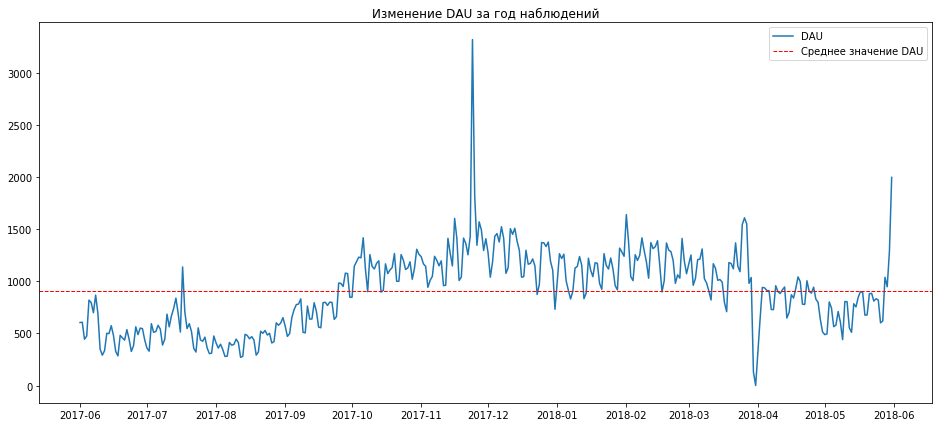

In [24]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot()
ax.plot(dau, label='DAU')
plt.axhline(y=dau_total.values, label='Среднее значение DAU', linewidth=1, color='r', ls='--')
plt.legend()
ax.xaxis.set_major_locator(MonthLocator())
plt.title('Изменение DAU за год наблюдений')
plt.show()

На графике виден прирост ежедневного количества пользователей в первые 4 месяца, после рост замедлился. В октябре 2017 года был резкий и краткосрочный скачок по количеству пользователей в день, после чего значение вернулось обратно. Возможно какое-то отдельное событие может объяснить этот рост (было бы хорошо узнать, были ли какие-то значительные в сервисе).
Начиная с марта 2018 после резкого падения началось снижение DAU вплоть до мая, когда снова виден резкий скачок. На этом исследуемый период заканчивается.
Возможно ответ на причины резких скачков и изменение ежедневной активности я найду в расходах на маркетинг.

In [25]:
wau = visits.groupby(['session_week']).agg({'uid':'nunique'})
wau.head()

,uid
session_week,
2017-05-29,2021
2017-06-05,4129
2017-06-12,2812
2017-06-19,2878
2017-06-26,3064


In [26]:
wau_total = wau.mean()
wau_total

uid    5716.245283
dtype: float64

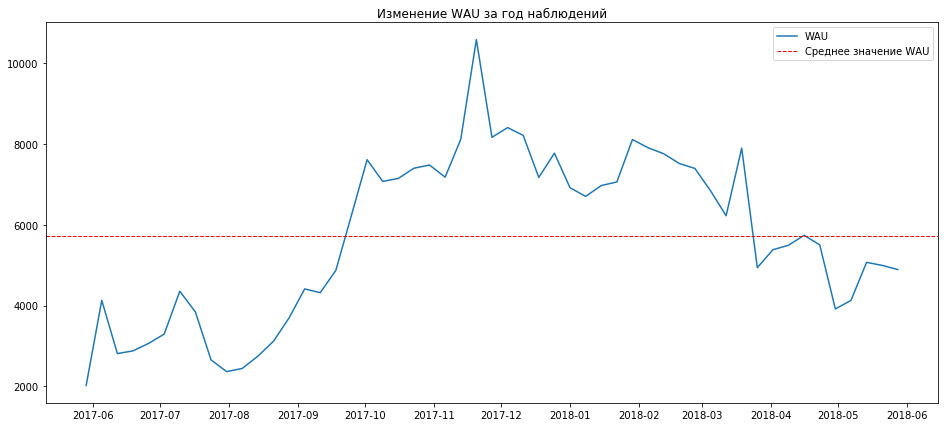

In [27]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot()
ax.plot(wau, label='WAU')
plt.axhline(y=wau_total.values, label='Среднее значение WAU', linewidth=1, color='r', ls='--')
plt.legend()
ax.xaxis.set_major_locator(MonthLocator())
plt.title('Изменение WAU за год наблюдений')
plt.show()

График с WAU напоминает график с DAU, но имеет значительно больший рост в тех интервалах, где в DAU есть изменения. Это может значить, что еженедльная аудитория сервиса приростала, но сервис не использовался большое количество раз в неделю. Сопоставим оба графика, для наглядности.

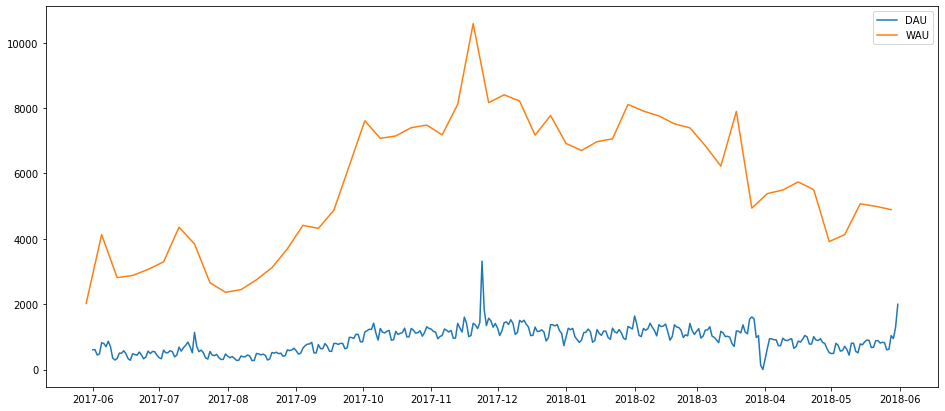

In [28]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot()
ax.plot(dau, label='DAU')
ax.plot(wau, label='WAU')
#plt.axhline(y=dau_total.values, label='Среднее значение DAU', linewidth=1, color='r', ls='--')
plt.legend()
ax.xaxis.set_major_locator(MonthLocator())
#plt.title('Изменение DAU за год наблюдений')
plt.show()

Исходя из графиков выходит, что ежедневное количество пользователей приростало незначительно, но еженедельное росло более активными темпами. Получается, что на начальном периоде пользователи чаще заходили в приложение в течение недели, а начиная с августа 2017 в течение недели стало заходить больше различных пользователей, но с меньше частотой по дням.

In [29]:
mau = visits.groupby('session_month').agg({'uid':'nunique'})
mau

,uid
session_month,
2017-06-01,13259
2017-07-01,14183
2017-08-01,11631
2017-09-01,18975
2017-10-01,29692
2017-11-01,32797
2017-12-01,31557
2018-01-01,28716
2018-02-01,28749


In [30]:
mau_total = mau.mean()
mau_total

uid    23228.416667
dtype: float64

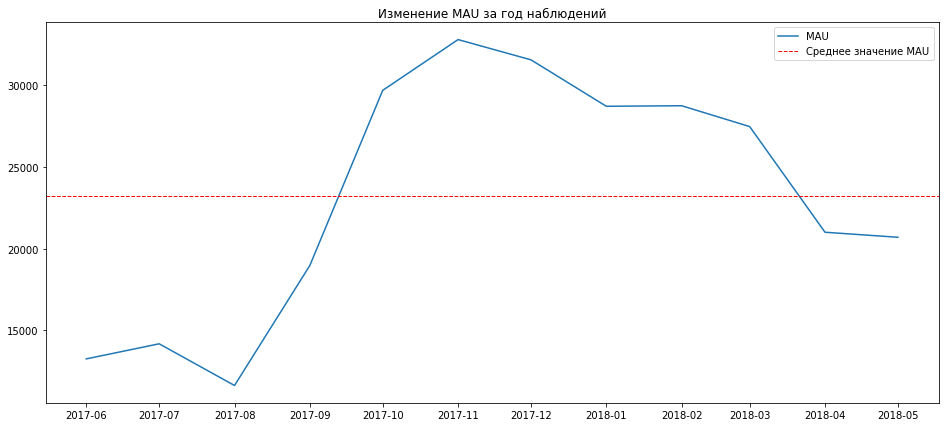

In [31]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot()
ax.plot(mau, label='MAU')
plt.axhline(y=mau_total.values, label='Среднее значение MAU', linewidth=1, color='r', ls='--')
plt.legend()
ax.xaxis.set_major_locator(MonthLocator())
plt.title('Изменение MAU за год наблюдений')
plt.show()

На графике с MAU мы видим, что количество пользователей, которые хотя бы раз заходят в сервис начало активно расти начиная с августа 2017 и вполть до ноября активно росло (нужно будет обратить внимание на этот период при анализе маркетинговых расходов), но далее начало постепенно снижаться. Получается что за период в 3 месяца ежемесячная аудитория сервиса выросла более чем в два раза, но после начала постепенно снижаться.

Дополнительно рассчитаю sticky factor для средних значений за год.

In [32]:
stickyf_weekly = dau_total/wau_total
stickyf_weekly

uid    0.158844
dtype: float64

In [33]:
stickyf_monthly = dau_total/mau_total
stickyf_monthly

uid    0.03909
dtype: float64

Как уже выяснилось ранее, получается что пользователь заходит чуть более одного раза в неделю в приложение (7*0,1588=1,1116) и примерно столько же раз в месяц. Вроде не очень хорошее значение, но хотя бы раз заходит.

### Количество сессий в день

In [34]:
daily_sessions_count = visits.groupby(['uid', 'session_date']).agg({'start_ts':'count'})
daily_sessions_count.mean()

start_ts    1.087414
dtype: float64

В среднем в день пользователи заходят чуть больше одного раза.

In [35]:
daily_sessions_by_date = daily_sessions_count.groupby('session_date').agg({'start_ts':'mean'})
daily_sessions_by_date

,start_ts
session_date,
2017-06-01,1.097521
2017-06-02,1.082237
2017-06-03,1.071910
2017-06-04,1.071429
2017-06-05,1.089024
...,...
2018-05-27,1.083871
2018-05-28,1.112608
2018-05-29,1.091772


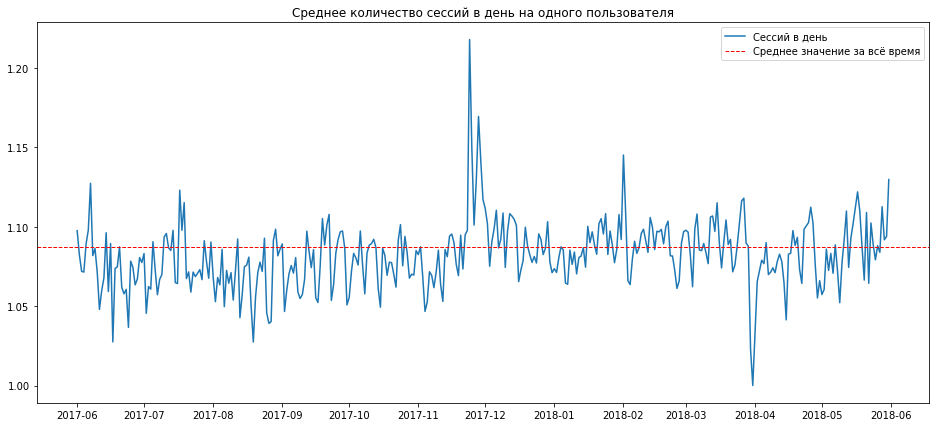

In [36]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot()
ax.plot(daily_sessions_by_date, label='Сессий в день')
plt.axhline(y=daily_sessions_count.mean().values, label='Среднее значение за всё время', linewidth=1, color='r', ls='--')
plt.legend()
ax.xaxis.set_major_locator(MonthLocator())
plt.title('Среднее количество сессий в день на одного пользователя')
plt.show()

Количество сессий колеблется вокруг среднего с незначительными изменениями, но имеет пиковые значения в тех же временных точках, где мы наблюдали увеличение DAU и WAU - это может говорить о том, что в сервисе происходило что-то интересное, что не только привлекло пользователей на сайт, но и заставляло их возвращаться на него в тот же день и после него.

### Длительность сессий

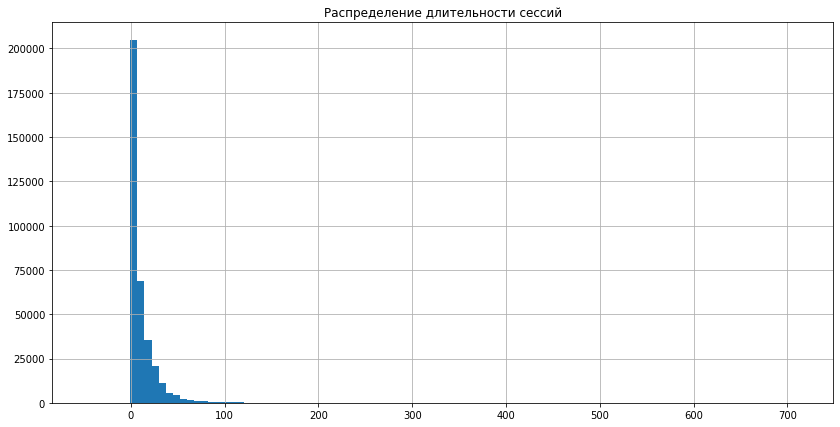

In [37]:
visits['session_len_min'].hist(bins=100, figsize=(14,7))
plt.title('Распределение длительности сессий')
plt.show()

По графику мы видим, что длительность сессий распределена не нормально. Большая часть значений сконцентрированы вначале оси x, при этом график имеет огромный хвост значений. Такой хвост обычно обусловлен тем, что пользователи оставляют сайт открытым длительное время не пользуясь им.

In [38]:
visits['session_len_min'].describe()

count    359400.000000
mean         10.716330
std          16.619282
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_len_min, dtype: float64

In [39]:
visits.query('session_len_min < 0')

,device,end_ts,source_id,start_ts,uid,session_len_min,session_year,session_month,session_date,session_week,first_visit_date
27980,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,-32,2018,2018-03-01,2018-03-25,2018-03-19,2017-11-12
59662,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,-46,2018,2018-03-01,2018-03-25,2018-03-19,2018-03-19


У двух записей время начала сессии было позже времени окончания сессии. Обе записи от 25 марта, примерно в одинаковое время и сессии начинаются в конце часа. Как раз в эту дату и примерно в это время в 2018 году осуществлялся перевод часов в России. Поэтому значение длительности сессии для этих значений необходимо пересчитать.

In [40]:
visits.loc[visits['session_len_min'] < 0, 'session_len_min'] = visits.loc[visits['session_len_min'] < 0, 'session_len_min'] + 60

In [41]:
visits['session_len_min'].describe()

count    359400.000000
mean         10.716664
std          16.618886
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_len_min, dtype: float64

In [42]:
visits['session_len_min'].mode()[0]

1

Чаще всего 1 сессия длится около 1 минуты, при этом половина всех пользователей проводит на сайте не более 5 минут. Большинство пользователей задерживаются на сайте не более чем на 15 минут.

Посмотрим, как изменяется среднее значение со временем. Для этого нужно сначала избавиться от большого количества чрезмерно длинных сессий.

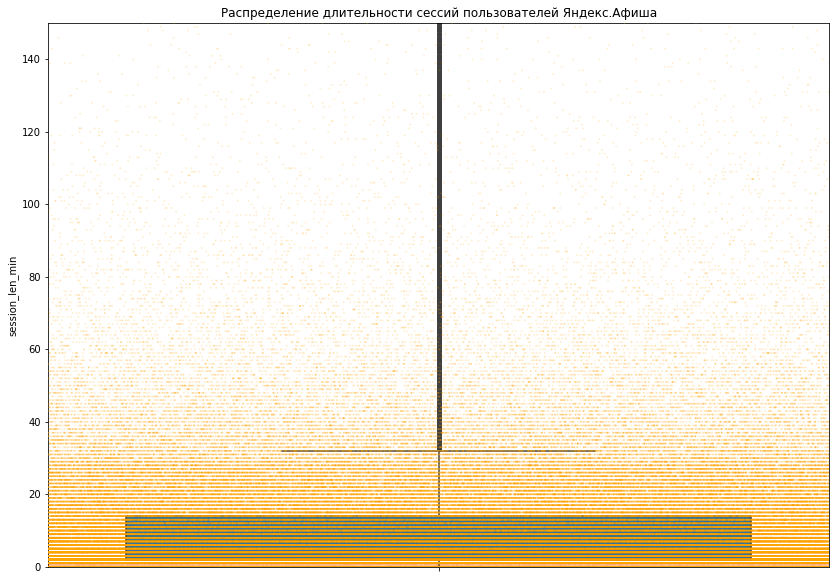

In [43]:
plt.figure(figsize=(14,10))
sns.stripplot(y=visits['session_len_min'], color='orange', jitter=0.5, size=1.8, alpha=0.2)
sns.boxplot(y=visits['session_len_min'])
plt.ylim(0,150)
plt.title("Распределение длительности сессий пользователей Яндекс.Афиша")
plt.show()

На основании такого своеобразного графика я возьму для расчёта среднего только значения ниже 60 минут.

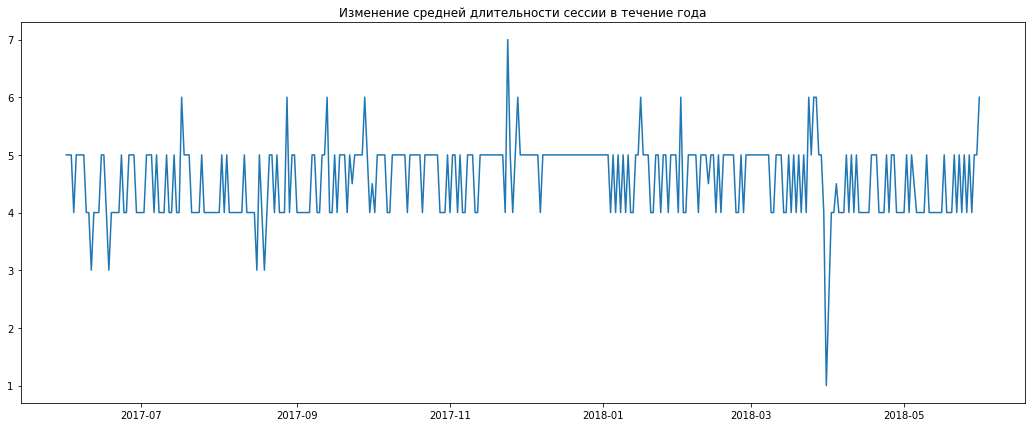

In [44]:
session_duration_by_date = visits.query('session_len_min <= 60').groupby('session_date').agg({'session_len_min':'median'})
plt.figure(figsize=(18,7))
plt.plot(session_duration_by_date, label='Средняя длительность сессии')
plt.title('Изменение средней длительности сессии в течение года')
plt.show()

По графику видно, что в течение года длительность сессии колеблется относительно медианного значения, кроме того видны пик и падения по дата совпадающие с аналогичными в других выше рассчитанных показателях.

### Retention rate

Для расчёта retention rate для каждого визита необходимо определить когда был первый визит этого пользователя и сколько месяцев с этого момента прошло.

In [45]:
visits['first_activity_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_len_min,session_year,session_month,session_date,session_week,first_visit_date,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18,2017,2017-12-01,2017-12-20,2017-12-18,2017-12-20,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28,2018,2018-02-01,2018-02-19,2018-02-19,2018-02-19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017,2017-07-01,2017-07-01,2017-06-26,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24,2018,2018-05-01,2018-05-20,2018-05-14,2018-03-09,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,28,2018,2018-03-01,2018-03-09,2018-03-05,2018-03-09,2018-03-01


In [46]:
visits['cohort_lifetime'] = ((visits['session_month'] - visits['first_activity_month'])/np.timedelta64(1,'M')).round().astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_len_min,session_year,session_month,session_date,session_week,first_visit_date,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18,2017,2017-12-01,2017-12-20,2017-12-18,2017-12-20,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28,2018,2018-02-01,2018-02-19,2018-02-19,2018-02-19,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017,2017-07-01,2017-07-01,2017-06-26,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24,2018,2018-05-01,2018-05-20,2018-05-14,2018-03-09,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,28,2018,2018-03-01,2018-03-09,2018-03-05,2018-03-09,2018-03-01,0


Сформирую когорты.

In [47]:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Также необходимо добавить значение изначального количества участников когорты, чтобы сравнивать с ним показатели по месяцам.

In [48]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count.columns = ['first_activity_month','cohort_users']
initial_users_count

,first_activity_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [49]:
cohorts = pd.merge(cohorts, initial_users_count, on='first_activity_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.041818
74,2018-03-01,2,557,20589,0.027053
75,2018-04-01,0,15709,15709,1.000000
76,2018-04-01,1,760,15709,0.048380


Визуализирую полученные данные.

In [50]:
retention_rates = cohorts.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='retention', aggfunc='mean')
retention_rates

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


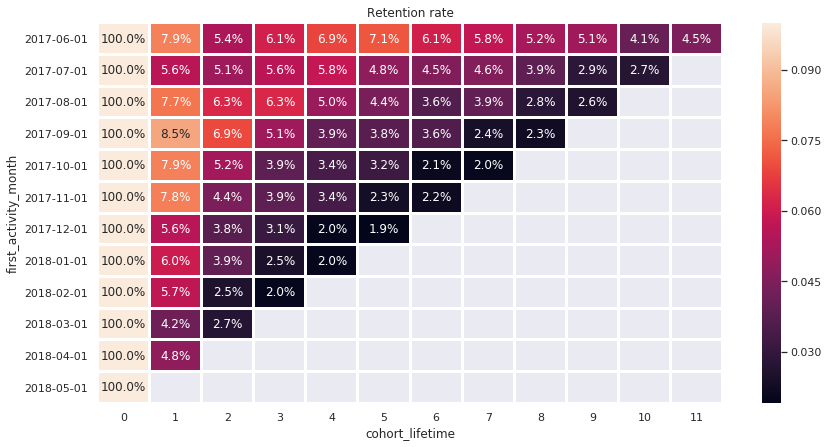

In [51]:
sns.set(style='darkgrid')
plt.figure(figsize=(14,7))
ax = sns.heatmap(retention_rates, annot=True, fmt='.1%', linewidths=2, linecolor='white', vmax=0.1)
plt.title('Retention rate')
ticklabels = [retention_rates.index[int(tick)].strftime('%Y-%m-%d') 
              for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);
plt.show()

Исходя из полученной таблицы видно, что после первого месяца происходит сильный отток из сервиса и далее не наблюдается значительных изменений. Т.е. retention rate быстро падает до своего регулярного значения, а не постепенно. При этом во многих когортах можно видеть небольшой прирост в 3-6 месяцы когорты.
Посмотрим как изменяется среднее значение во времени.

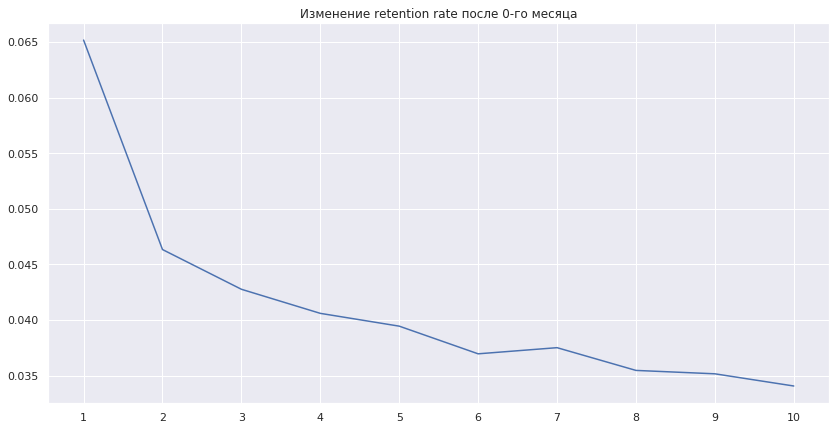

In [52]:
sns.set(style='darkgrid', palette='deep')
plt.figure(figsize=(14,7))
plt.plot(retention_rates.mean()[1:11])
plt.title('Изменение retention rate после 0-го месяца')
plt.xticks(range(1,11))
plt.show()

На графике мы видимо, что retention rate продолжает снижаться и далее, но уже более спокойными темпами, что вполне нормально.

In [53]:
retention_rates.mean()[1:11]

cohort_lifetime
1     0.065167
2     0.046333
3     0.042760
4     0.040595
5     0.039444
6     0.036957
7     0.037509
8     0.035465
9     0.035159
10    0.034062
dtype: float64

Retention rate во второй месяц жизни когорт в среднем равен значению указанному ниже.

In [54]:
retention_rates.mean()[1]

0.06516659710392834

### Время до первой покупки

Для того, чтобы узнать среднее время от первого входа пользователя в сервис до первой покупки, нужно рассчитать это значение предварительно для каждого отдельного пользователя. Поэтому я соберу в одну таблицу данные о первой покупке и о первом входе для каждого uid.

In [55]:
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.head()

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [56]:
first_orders = pd.merge(first_orders, visits.groupby('uid')['start_ts'].min(), on='uid', how='left')
first_orders.head(15)

,uid,buy_ts,start_ts
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
5,3077748354309989,2018-03-03 12:33:00,2018-03-03 12:08:00
6,3605148382144603,2017-09-21 20:56:00,2017-08-15 21:54:00
7,3753586865891862,2018-03-03 13:50:00,2018-03-03 13:47:00
8,4808417689019433,2018-01-09 23:32:00,2018-01-09 23:10:00
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00


In [57]:
first_orders['time_to_first_buy'] = first_orders['buy_ts'] - first_orders['start_ts']
first_orders.head()

,uid,buy_ts,start_ts,time_to_first_buy
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0 days 01:19:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0 days 19:44:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00


In [58]:
first_orders['ttfb_min'] = first_orders['time_to_first_buy']/np.timedelta64(1, 'm')
first_orders.head()

,uid,buy_ts,start_ts,time_to_first_buy,ttfb_min
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0 days 01:19:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0 days 19:44:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00,0.0


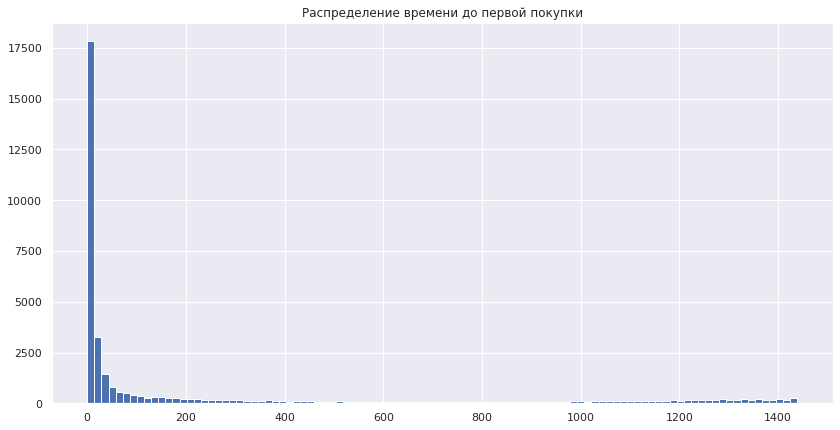

In [59]:
plt.figure(figsize=(14,7))
plt.hist(first_orders['time_to_first_buy'].dt.seconds/60, bins=100)
plt.title('Распределение времени до первой покупки')
plt.show()

У большого количества записей время первого входа совпадает со временем покупки. В реальности это кажется маловероятным, возможно только если пользователь принял решение и ввёл все данные не заходя на сам сервис. Вероятнее всего, вход в сессию просто не регистрировался до входа пользователя либо он не был идентифицирован до выполнения оплаты. Такие даные для анализа не подходят, поэтому я исключу их.

In [60]:
first_orders.query('time_to_first_buy == @timedelta(seconds=0)')['time_to_first_buy'].count()

2455

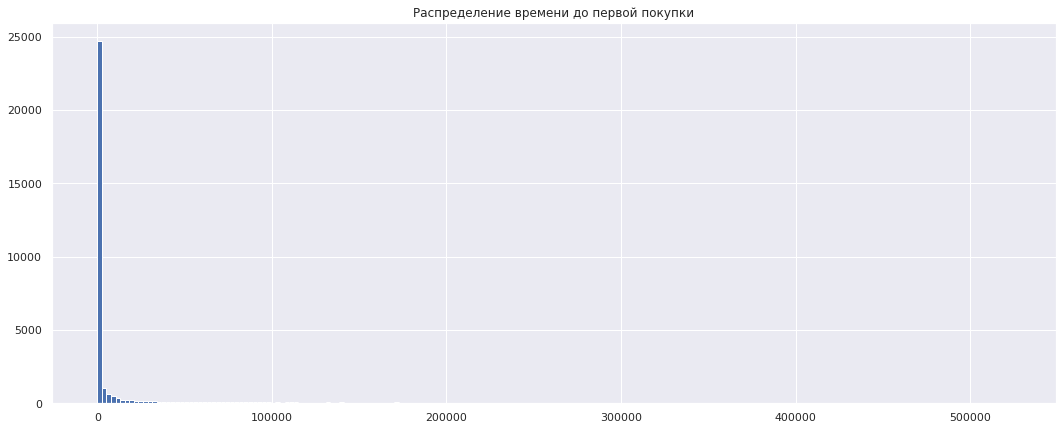

In [61]:
plt.figure(figsize=(18,7))
plt.hist(first_orders.query('time_to_first_buy > @timedelta(seconds=0)')['ttfb_min'], bins=200)
plt.title('Распределение времени до первой покупки')
plt.show()

Исходя из графика всё равно видно, что большая часть пользователей делаю первую покупку достаточно быстро, после первого входа. А для остальных этот срок растягивается на месяцы вперёд.

In [62]:
first_orders.query('time_to_first_buy > @timedelta(seconds=0)')['ttfb_min'].describe()

count     34068.000000
mean      26094.171715
std       69857.874308
min           1.000000
25%           5.000000
50%          21.000000
75%        4438.000000
max      523144.000000
Name: ttfb_min, dtype: float64

In [63]:
first_orders['ttfb_min'].mode()

0    1.0
dtype: float64

Среднее время до первой покупки для оценки подойдёт не очень, т.к. есть очень большой хвост по длительности (до нескольких месяцев). Значение моды также не будет показательным для оценки все совокупности, поэтому как вывод я буду использовать медиану - половина пользователей выполняет свою первую покупку в течение 21 минуты с первого входа в сервис.

### Средний чек

Для расчёта среднего чека по месяцам нужно только определить в каком месяце была совершена покупка. Для этого я добавлю соответствующий столбец в таблицу и сделаю по нему группировку.

In [64]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [65]:
orders.groupby('order_month')['revenue'].mean()

order_month
2017-06-01    4.060106
2017-07-01    5.306589
2017-08-01    4.847139
2017-09-01    5.416448
2017-10-01    4.928280
2017-11-01    4.783518
2017-12-01    5.852139
2018-01-01    4.112927
2018-02-01    4.840095
2018-03-01    5.413930
2018-04-01    5.150645
2018-05-01    4.771279
2018-06-01    3.420000
Name: revenue, dtype: float64

Средний чек за весь период наблюдений:

In [66]:
orders['revenue'].mean()

4.999646930477041

In [67]:
'Средний чек, у.е.: {}'.format( orders['revenue'].mean().round(4))

'Средний чек, у.е.: 4.9996'

Теперь можно посмотреть, как средний чек изменялся в течение наблюдаемого периода.

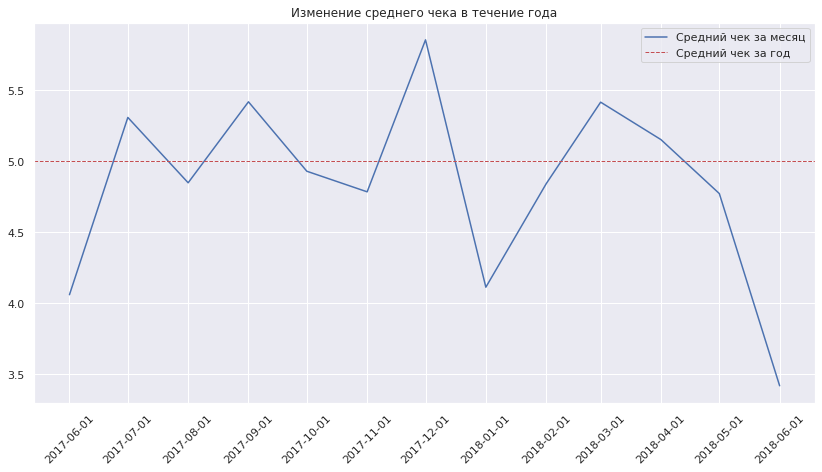

In [68]:
sns.set(style='darkgrid', palette='deep')
plt.figure(figsize=(14,7))
plt.plot(orders.groupby('order_month')['revenue'].mean(), label='Средний чек за месяц')
plt.title('Изменение среднего чека в течение года')
plt.xticks(orders.groupby('order_month')['revenue'].mean().index, rotation=45)
plt.axhline(y=orders['revenue'].mean(), linewidth=1, color='r', ls='--', label='Средний чек за год')
plt.legend()
plt.show()

Исходя из графика средний чек в течение года колебался между 4 и 6 у.е., снова виден пик в декабре 2017 года (может это под новый год была какая-то движуха) и резкое падение в январе. Среднее значение за весь наблюдаемый год - 5 у.е. Также на графике видно резкое и сильное падение в июне 2018 - это одна единственная покупка, случайно попавшая в выборку, на основании неё нельзя делать выводы, но обратив внимание на июнь 2017 можно также увидеть низкий средний чек. Если такой тренд можно объяснить сезонностью - можно придумать какие-то спецпредложения на этот период (если посмотреть на графики MAU и DAU - можно увидеть также, что май и июнь периоды не активные).

In [69]:
orders.query('order_month == "2018-06-01"')

,buy_ts,revenue,uid,order_month
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01


### Расчёт LTV

Для расчёта LTV нужно разделить пользователей на когорты, а также собрать значения по покупкам за исследуемые периоды.

In [70]:
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [71]:
orders = pd.merge(orders, visits.groupby('uid')['first_activity_month'].min().reset_index(), on='uid')
orders

,buy_ts,revenue,uid,order_month,first_activity_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2017-10-01


In [72]:
orders['cohort_lifetime'] = ((orders['order_month'] - orders['first_activity_month'])/ np.timedelta64(1, 'M')).round().astype('int')
orders.tail(20)

,buy_ts,revenue,uid,order_month,first_activity_month,cohort_lifetime
50395,2018-05-31 22:50:00,2.44,15116668155510764243,2018-05-01,2018-05-01,0
50396,2018-05-31 22:58:00,0.85,11637259703803638683,2018-05-01,2018-05-01,0
50397,2018-05-31 23:01:00,0.24,8971807372263051413,2018-05-01,2018-04-01,1
50398,2018-05-31 23:01:00,1.16,4326846074047313748,2018-05-01,2018-05-01,0
50399,2018-05-31 23:02:00,7.33,10899818686660841329,2018-05-01,2018-05-01,0
50400,2018-05-31 23:03:00,2.75,17036314177686040355,2018-05-01,2018-05-01,0
50401,2018-05-31 23:04:00,7.33,3251741041959686640,2018-05-01,2018-05-01,0
50402,2018-05-31 23:13:00,6.72,11767206187037456942,2018-05-01,2018-05-01,0
50403,2018-05-31 23:14:00,0.30,5877288373018804921,2018-05-01,2018-05-01,0
50404,2018-05-31 23:30:00,5.50,5300693976971713685,2018-05-01,2018-05-01,0


In [73]:
cohort_sizes = orders.groupby('first_activity_month').agg({'uid':'nunique', 'cohort_lifetime':'max'}).reset_index()
cohort_sizes.columns = ['first_activity_month', 'n_buyers', 'cohort_age']
cohort_sizes

,first_activity_month,n_buyers,cohort_age
0,2017-06-01,2923,11
1,2017-07-01,2458,10
2,2017-08-01,1721,9
3,2017-09-01,3058,8
4,2017-10-01,4678,7
5,2017-11-01,4262,6
6,2017-12-01,4074,5
7,2018-01-01,3119,4
8,2018-02-01,3186,3
9,2018-03-01,2838,2


In [74]:
orders = pd.merge(orders,cohort_sizes, on='first_activity_month')
orders['ltv'] = orders['revenue']/orders['n_buyers']

In [75]:
ltv_table = orders.query('cohort_age > 4 & cohort_lifetime < 6').pivot_table(index='first_activity_month', columns='cohort_lifetime', values='ltv', aggfunc='sum').cumsum(axis=1)

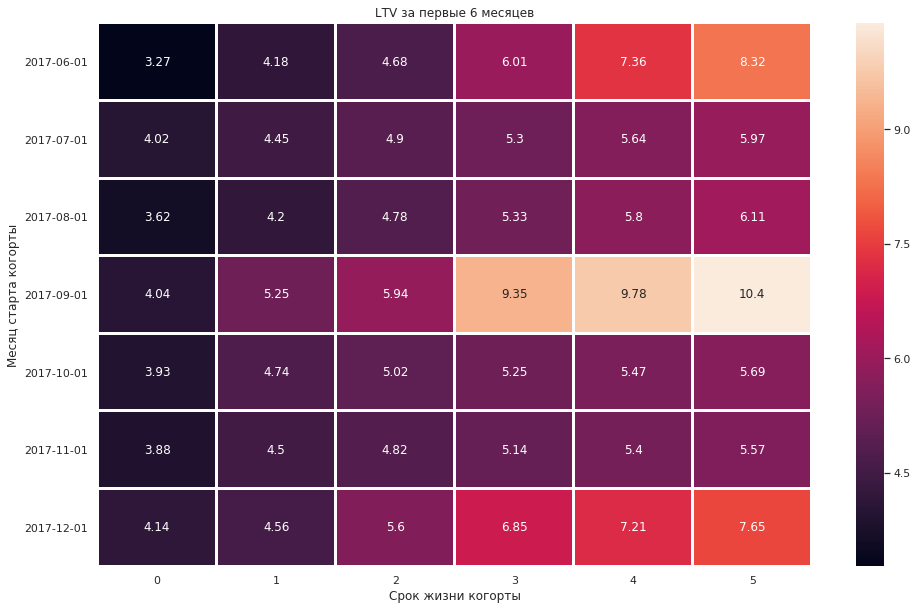

In [76]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(ltv_table,annot=True, fmt='.3', linewidths=2, linecolor='white')
plt.title("LTV за первые 6 месяцев")
plt.ylabel('Месяц старта когорты')
plt.xlabel('Срок жизни когорты')
ticklabels = [ltv_table.index[int(tick)].strftime('%Y-%m-%d') 
              for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);
plt.show()

Исходя из расчитанных показателей наиболее успешными к 6-му месяцу жизни получились когорты июня, сентября и декабря 2017 года. В большинстве случаев пользователи приносят основную часть прибыли в первый месяц, но для этих когорт получилось к 6-му месяцу увеличить LTV в два и более раз относительно первого месяца для этих групп. Нужно обратить внимание и начать делать также с остальными.

Средний LTV к 6-му месяцу в среднем достигает:

In [77]:
ltv_table[5].mean()

7.102173342923256

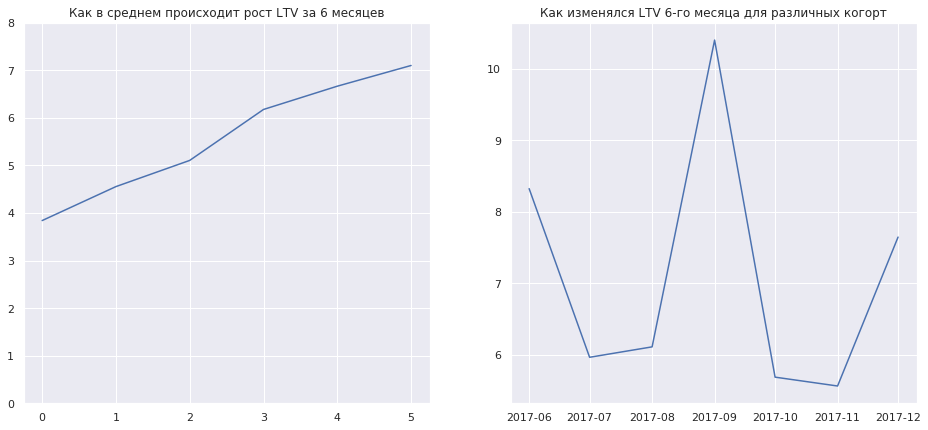

In [78]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16,7))

ax1.plot(ltv_table.mean(axis=0))
ax1.set_title('Как в среднем происходит рост LTV за 6 месяцев')
ax1.set_ylim(0,8)

ax2.plot(ltv_table[5])
ax2.set_title('Как изменялся LTV 6-го месяца для различных когорт')
plt.show()

Как мы уже выяснили из таблицы выше, наиболее успешными по LTV были когорты июня, сентября и декабря 2017 года.

In [79]:
orders.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='ltv', aggfunc='sum').cumsum(axis=1)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,3.269754,4.181345,4.682436,6.010554,7.358686,8.324981,9.518943,10.295819,11.088809,12.279928,13.033951,13.693483
2017-07-01,4.017449,4.448401,4.899540,5.299443,5.644028,5.968714,6.207933,6.521318,6.816078,7.056530,7.246587,NaN
2017-08-01,3.622783,4.202284,4.784126,5.333928,5.804608,6.114253,6.397025,7.121156,7.603806,7.822121,NaN,NaN
2017-09-01,4.040942,5.251040,5.941239,9.354886,9.776233,10.400840,10.717008,10.877695,11.014572,NaN,NaN,NaN
2017-10-01,3.925250,4.739664,5.023337,5.249513,5.472572,5.691082,5.814833,5.955043,NaN,NaN,NaN,NaN
2017-11-01,3.878881,4.504779,4.819855,5.141190,5.401335,5.567367,5.731281,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.137703,4.564563,5.595074,6.852761,7.210535,7.647975,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.397567,4.023312,4.396752,4.494822,4.663937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.613506,4.236375,4.444532,4.727335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


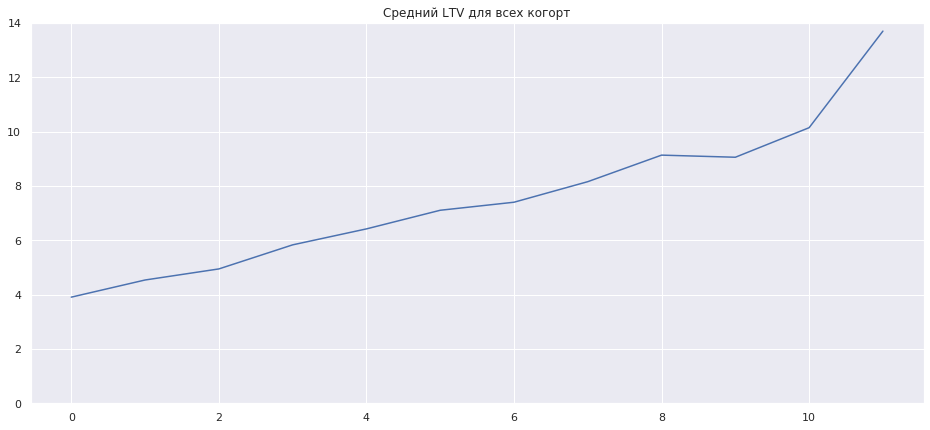

In [80]:
plt.figure(figsize=(16,7))
plt.plot(orders.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='ltv', aggfunc='sum').cumsum(axis=1).mean(axis=0))
plt.title('Средний LTV для всех когорт')
plt.ylim(0,14)
plt.show()

При этом если посмотреть на LTV всех когорт, наблюдается продолжительный рост (плато пока не видно), что может говорить о том, что пользователи продолжают использовать сервис (мы уже видели, что retention rate не сильно снижается после второго месяца). Показатели за последние месяцы основны на меньшем количестве когорт, но факт рост они не опровергают.

### Среднее количество покупок на одного пользователя за 6 месяцев

Для того, чтобы понять, сколько пользователь делает покупок и на какие суммы я использую когортный анализ. Я буду рассчитывать среднее количество покупок на одного пользователя за первые 6 месяцев его жизни в сервисе (а не за 6 месяцев с первой покупки).
После расчёта LTV пользователи у меня уже поделены на когорты относительно месяца первого входа на сайт.

In [81]:
six_month_shoping = orders.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'count', 'n_buyers':'mean'}).reset_index()
six_month_shoping['n_sales'] = six_month_shoping['uid']/six_month_shoping['n_buyers']

In [82]:
shoping_pivot = six_month_shoping.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='n_sales', aggfunc='mean').cumsum(axis=1)

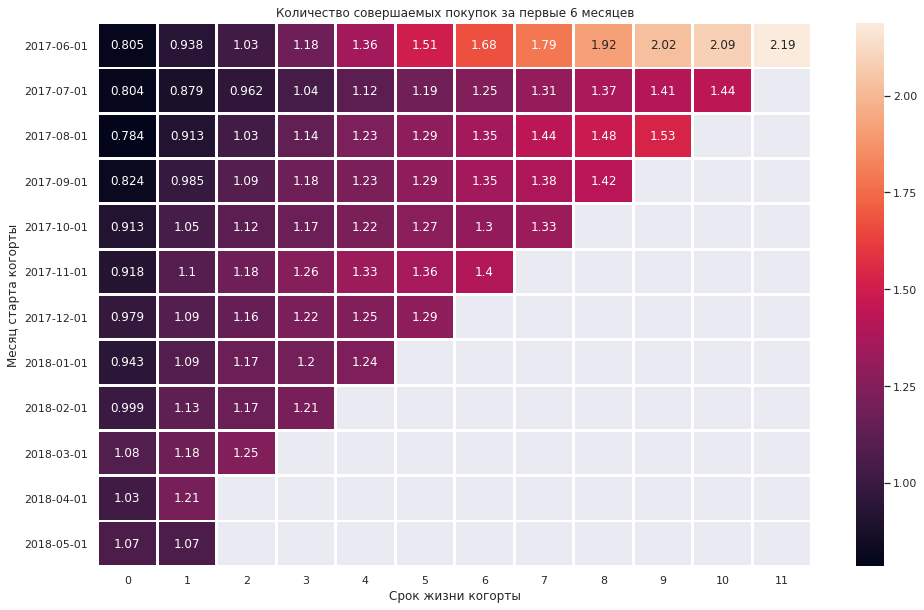

In [83]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(shoping_pivot,annot=True, fmt='.3', linewidths=2, linecolor='white')
plt.title("Количество совершаемых покупок за первые 6 месяцев")
plt.ylabel('Месяц старта когорты')
plt.xlabel('Срок жизни когорты')
ticklabels = [shoping_pivot.index[int(tick)].strftime('%Y-%m-%d') 
              for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);
plt.show()

Исходя из полученных данных видно, что первая покупка не в более ранних когортах не всегда совершалась в первый или даже второй месяц, но в последних трёх этот показатель улучшился. При этом видно, что в первой когорте к 10 месяцу все пользователи уже совершили по две покупки, а в двух следующих когортах к этому времени в среднем было только по 1,5 покупок.

In [84]:
shoping_pivot[5].mean()

1.3134776062090485

По имеющимся данным получается, что за первые 6 месяцев в сервисе пользователи совершают в среднем 1,31 покупок за первые 6 месяцев своей активности. При этом, как выяснилось выше, хотя бы раз в месяц заходят в сервис.

### Маркетинговые метрики

Первым делом посмотрим на общие расходы на маркетинг.

In [85]:
'Общие расходы на маркетинг, у.е.: {}'.format( costs['costs'].sum())

'Общие расходы на маркетинг, у.е.: 329131.62'

In [86]:
costs.groupby('source_id')['costs'].sum().sort_values(ascending=False)

source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64

На источник 3 расходуется больше всего средств, при этом 10 и 9 забирают на себя наименьшую часть.

Теперь я соберу в одну таблицу данные по месяцам и по источникам трафика о затратах на эти источники и количестве пришедших по ним пользователей.

In [87]:
fi_users = visits.groupby(['uid'])[['start_ts','source_id']].min().reset_index()
fi_users['month'] = fi_users['start_ts'].astype('datetime64[M]')
fi_users

,uid,start_ts,source_id,month
0,11863502262781,2018-03-01 17:27:00,3,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2,2018-02-01
2,297729379853735,2017-06-07 18:47:00,3,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2,2017-09-01
4,325320750514679,2017-09-30 14:29:00,5,2017-09-01
...,...,...,...,...
228164,18446403737806311543,2017-11-30 03:36:00,5,2017-11-01
228165,18446424184725333426,2017-12-06 20:32:00,4,2017-12-01
228166,18446556406699109058,2018-01-01 16:29:00,3,2018-01-01
228167,18446621818809592527,2017-12-27 13:27:00,4,2017-12-01


In [88]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [89]:
report = pd.merge(fi_users.groupby(['month', 'source_id'])['uid'].count(), costs.groupby(['month', 'source_id'])['costs'].sum(), on=['month', 'source_id'])
report

uid    costs
month      source_id               
2017-06-01 1          1513  1125.61
           2          1689  2427.38
           3          4029  7731.65
           4          2988  3514.80
           5          2262  2616.12
...                    ...      ...
2018-05-01 3          3738  9411.42
           4          5118  4214.21
           5          2827  3669.56
           9           300   362.17
           10          544   409.86

[84 rows x 2 columns]

### Расходы на маркетинг по месяцам

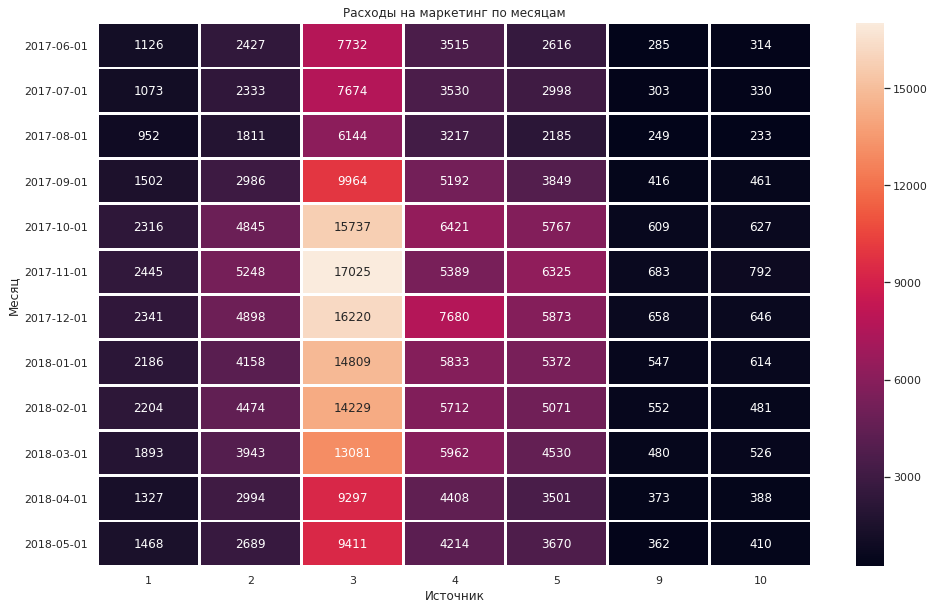

In [90]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(report.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum'),
            annot=True, 
            fmt='2.0f', 
            linewidths=2, 
            linecolor='white')
plt.title("Расходы на маркетинг по месяцам")
plt.ylabel('Месяц')
plt.xlabel('Источник')
ticklabels = [report.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum').index[int(tick)].strftime('%Y-%m-%d') 
              for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);
plt.show()

Кроме наиболее затратных источников в таблице видно, что наибольшая активность по месяцам была с сентября 2017 по март 2018. Теперь посмотрим, как выглядят результаты по привлечённым пользователям.

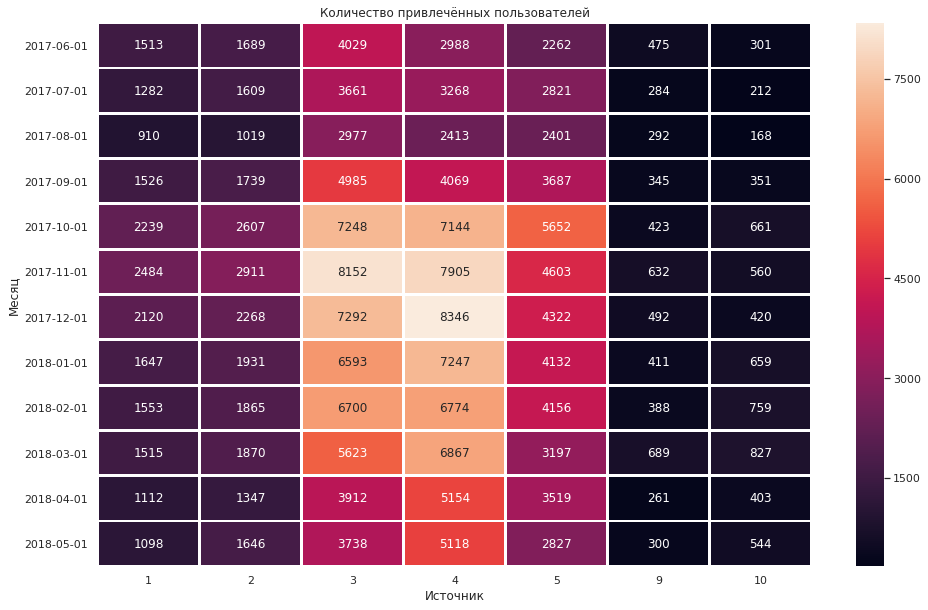

In [91]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(report.pivot_table(index='month', columns='source_id', values='uid', aggfunc='sum'),
            annot=True, 
            fmt='2.0f', 
            linewidths=2, 
            linecolor='white')
plt.title("Количество привлечённых пользователей")
plt.ylabel('Месяц')
plt.xlabel('Источник')
ticklabels = [report.pivot_table(index='month', columns='source_id', values='uid', aggfunc='sum').index[int(tick)].strftime('%Y-%m-%d') 
              for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);
plt.show()

Если взглянуть на результаты каналов трафика, то 2 канал уже не такой "красный", а вот 5 стал поярче. Также видно, что источник 4 оказался самым результативным в апреле и мае 2018 года, хотя по затратам был в два раза ниже чем источник 3. Для того, чтобы наглядно увидеть эффективность каждого канала посчитаем стоимость привлечения 1-го пользователя и визиализируем данные снова.

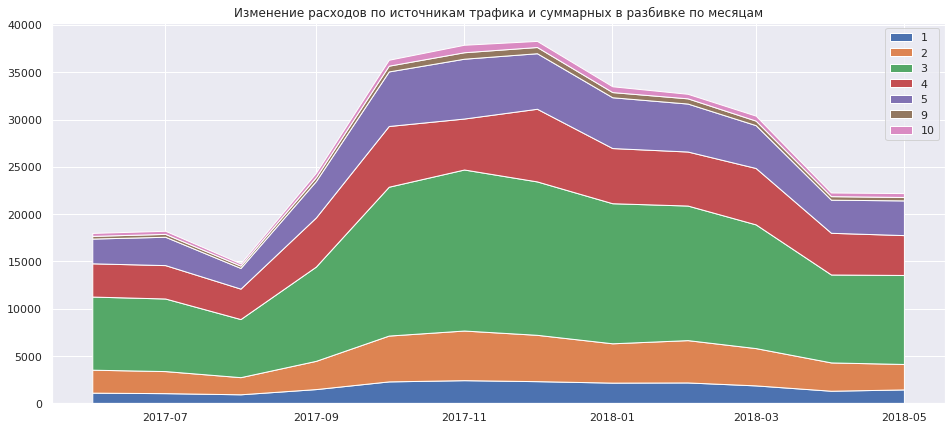

In [92]:
df = costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')
plt.figure(figsize=(16,7))
plt.stackplot(df.index, df[1], df[2],df[3],df[4],df[5],df[9],df[10], labels=df.columns)
plt.legend()
plt.title('Изменение расходов по источникам трафика и суммарных в разбивке по месяцам')
plt.show()

Исходя из графика можно подтвердить вывод о том, что 3 канал забирал наибольшую часть бюджета. Кроме того можно увидеть значительный рост расходов на этот канал начиная с августа 2017 года, в том время, как в других каналах прирост был незначительный. При этом на графике видно, что наиболее активный сезон с позиции маркетинговых расходов с октября по март, летние месяцы позволяют потратить оставшиеся средства на отпуск.

### CAC

In [93]:
report['cac'] = report['costs']/report['uid']

Среднее значение CAC среди всех пользователей сервиса равно:

In [94]:
report['costs'].sum()/report['uid'].sum()

1.4426802081187344

In [95]:
report_avg_cac = report.reset_index().groupby('month')[['uid','costs']].sum()
report_avg_cac['cac'] = report_avg_cac['costs']/report_avg_cac['uid']
report_avg_cac

,uid,costs,cac
month,,,
2017-06-01,13257,18015.00,1.358905
2017-07-01,13137,18240.59,1.388490
2017-08-01,10180,14790.54,1.452902
2017-09-01,16702,24368.91,1.459041
2017-10-01,25974,36322.88,1.398432
2017-11-01,27247,37907.88,1.391268
2017-12-01,25260,38315.35,1.516839
2018-01-01,22620,33518.52,1.481809
2018-02-01,22195,32723.03,1.474342


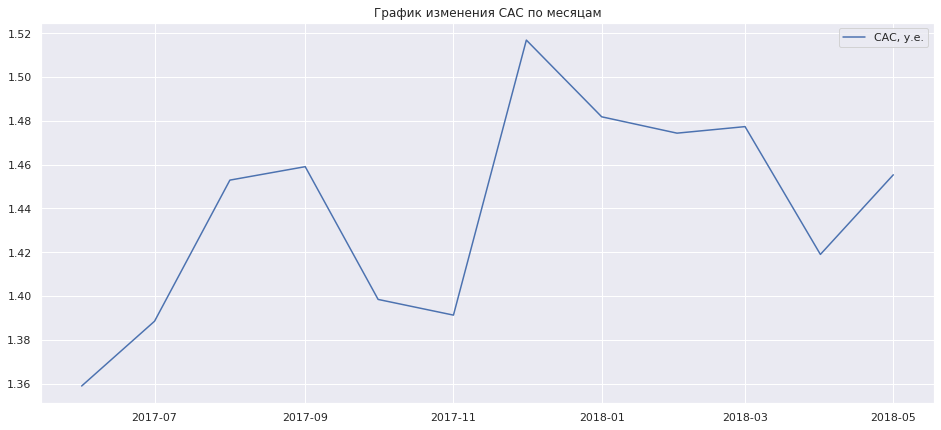

In [96]:
plt.figure(figsize=(16,7))
plt.plot(report_avg_cac['cac'], label='CAC, у.е.',)
plt.legend()
plt.title('График изменения CAC по месяцам')
#plt.ylim(0,1.6)
plt.show()

CAC достаточно активно изменяется в течение года. С сентября видно падение и резкий рост только в декабре, с небольшим снижением к марту. Это может говорить о том, что подход маркетинга "готовить сани летом" позволяет осенью получать аудиторию по небольшой стоимости в бОльших количества и уверенно приходить к декабрю, когда остальные рекламодатели начинают рекламироваться и каналы становятся дороже.

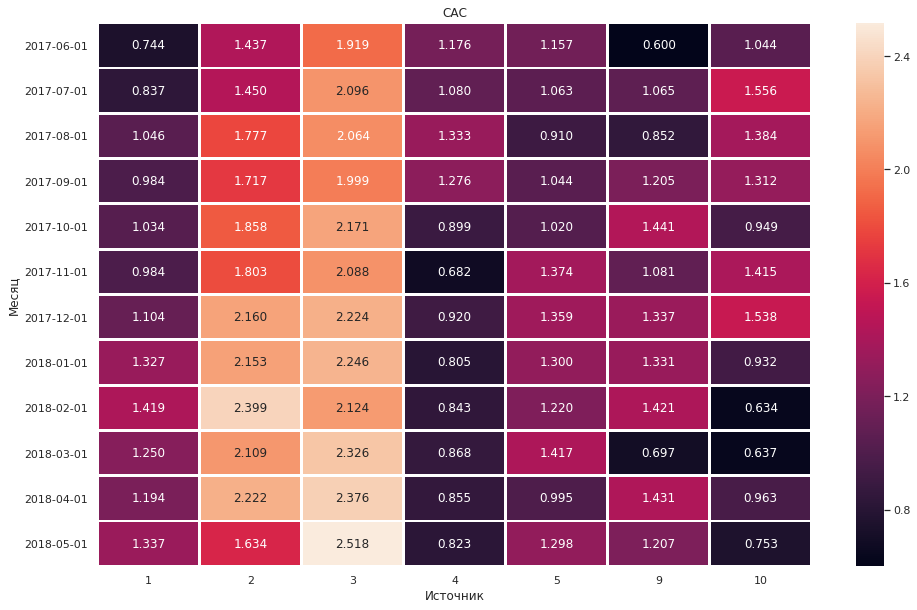

In [97]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(report.pivot_table(index='month', columns='source_id', values='cac', aggfunc='mean'),
            annot=True, 
            fmt='.3f', 
            linewidths=2, 
            linecolor='white')
plt.title("CAC")
plt.ylabel('Месяц')
plt.xlabel('Источник')
ticklabels = [report.pivot_table(index='month', columns='source_id', values='cac', aggfunc='mean').index[int(tick)].strftime('%Y-%m-%d') 
              for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);
plt.show()

Источник 3 выглядит как источник с самой высокой стоимостью привлечения клиента. К сожалению, нет доступа к информации о том, что это за источники, чтобы понять рационален ли выбор источника (сложно оценить качество трафика, объем трафика который можно привлекать из конкретного канала и пр), но уже можно сказать маркетолагам, что есть над чем поработать:
 - 3 канал самый дорогой по стоимости привлечения 1 пользователя и на него тратится больше всего средств, возможно есть смысл перераспределить бюджет на другие каналы
 - обратить внимание на 1, 4, 9 и 10 каналы - они вероятно могут давать новых пользователей по стоимости ниже

In [98]:
total_report = report.pivot_table(index='source_id', values=['uid', 'costs'], aggfunc='sum')
total_report['cac_total'] = total_report['costs']/total_report['uid']
total_report['budget_part'] = total_report['costs']/total_report['costs'].sum()*100
total_report['users_part'] = total_report['uid']/total_report['uid'].sum()*100
total_report

,costs,uid,cac_total,budget_part,users_part
source_id,,,,,
1,20833.27,18999,1.096546,6.329769,8.327818
2,42806.04,22501,1.902406,13.005751,9.862847
3,141321.63,64910,2.177193,42.937725,28.451953
4,61073.60,67293,0.907577,18.555981,29.496491
5,51757.10,43579,1.187661,15.725350,19.101951
9,5517.49,4992,1.105266,1.676378,2.188140
10,5822.49,5865,0.992752,1.769046,2.570801


    CAC_total - средняя за 12 месяцев стоимость привлечения одного пользователя из конкретного канала.
3 канал забрал 42% рекламного бюджета и дал лишь 28% новых пользователей, в то время как 4-й канал - за 18% бюджета дал 29% всей аудитории. Снова же исходя из таблицы нужно обратить внимание маркетологов на 1. 4, 5, 9 и 10 каналы - они выглядят эффективнее остальных.
    При этом LTV в первый месяц у нас начинается с 3,27, поэтому можно сказать, что с ключевой задачей маркетологи справляются и рекламный бюджет окупается уже в первый месяц.

### Расчёт ROMI

Для расчёта ROMI по когортам и источникам нужно предварительно посчитать LTV по каждому каналу для каждой когорты. Я сделаю это в одной таблице, немного изменив процесс расчёта использованный выше.

In [99]:
orders = orders.merge(fi_users[['uid', 'source_id']], on='uid')
orders

,buy_ts,revenue,uid,order_month,first_activity_month,cohort_lifetime,n_buyers,cohort_age,ltv,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,0,2923,11,0.005816,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,0,2923,11,0.000188,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,0,2923,11,0.000127,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,0,2923,11,0.000188,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,0,2923,11,0.000127,3
...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:42:00,0.92,15854392578508828030,2018-05-01,2018-05-01,0,2316,1,0.000397,4
50411,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01,0,2316,1,0.002003,4
50412,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01,0,2316,1,0.002504,10
50413,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01,0,2316,1,0.000130,3


In [100]:
cohorts_sizes = orders.groupby(['first_activity_month', 'source_id'])['uid'].nunique().reset_index()
cohorts_sizes.columns = ['first_activity_month', 'source_id', 'n_buyers2']
cohorts_sizes

,first_activity_month,source_id,n_buyers2
0,2017-06-01,1,706
1,2017-06-01,2,553
2,2017-06-01,3,807
3,2017-06-01,4,424
4,2017-06-01,5,308
...,...,...,...
80,2018-05-01,3,585
81,2018-05-01,4,554
82,2018-05-01,5,358
83,2018-05-01,9,23


In [101]:
orders = pd.merge(orders, cohorts_sizes, on=['first_activity_month', 'source_id'])
orders['ltv_by_source'] = orders['revenue']/orders['n_buyers2']

In [102]:
ltv_by_sources_tbl = orders.query(
    'cohort_age > 4 & cohort_lifetime < 6').groupby(
    ['first_activity_month', 'source_id', 'cohort_lifetime'])['ltv_by_source'].sum().reset_index().pivot_table(
    index=['first_activity_month', 'source_id'], columns='cohort_lifetime', values='ltv_by_source', aggfunc='mean').fillna(0).cumsum(axis=1)
ltv_by_sources_tbl

cohort_lifetime                        0         1          2          3  \
first_activity_month source_id                                             
2017-06-01           1          3.631501  5.894051   7.487040  12.332465   
                     2          3.553418  4.907378   5.180344   5.623436   
                     3          2.604064  2.717906   2.856568   2.963209   
                     4          3.327972  3.749929   3.867429   4.096085   
                     5          4.208799  4.362078   4.432273   4.526104   
                     9          1.624912  1.633509   1.734386   1.734386   
                     10         1.869706  1.869706   1.869706   1.932647   
2017-07-01           1          4.159097  5.483876   6.731062   7.804885   
                     2          4.130359  4.421627   4.728373   4.986411   
                     3          3.610100  3.760250   3.988103   4.214626   
                     4          4.072526  4.233486   4.394217   4.624489   
                     5          4.660186  4.696429   4.875994   4.926242   
                     9          3.037273  3.292727   3.422121   3.504545   
                     10         1.932250  1.972000   1.972000   2.048250   
2017-08-01           1          3.946984  5.467582   6.894076   8.569565   
                     2          3.108039  3.735647   4.314824   4.724549   
                     3          3.609762  3.948143   4.362500   4.631310   
                     4          3.698642  3.967222   4.174691   4.398302   
                     5          4.076950  4.231383   4.310674   4.387801   
                     7          1.220000  1.220000   1.220000   1.220000   
                     9          1.908636  2.022500   3.313409   3.723636   
                     10         1.496667  1.496667   1.804074   1.804074   
2017-09-01           1          5.397400  9.240015  11.584508  26.774554   
                     2          3.420043  4.260929   5.005745   5.507387   
                     3          3.865478  4.307219   4.431463   4.640048   
                     4          3.192306  3.697989   3.886697   4.073173   
                     5          4.549937  4.817390   4.865344   4.965470   
                     9          2.012500  2.113250   2.423250   2.469000   
                     10         1.377368  2.112632   2.138246   2.309825   
2017-10-01           1          4.943480  7.371888   8.151570   8.721229   
                     2          3.978803  4.959944   5.181113   5.523465   
                     3          3.354799  3.800670   4.029255   4.143032   
                     4          3.380173  3.591911   3.725234   3.854014   
                     5          4.787749  4.971871   5.032939   5.066798   
                     9          2.311818  2.882727   3.016000   3.188182   
                     10         2.144071  2.164643   2.210929   2.216786   
2017-11-01           1          4.615967  5.782894   6.664190   7.466489   
                     2          3.809522  4.363436   4.592049   4.821618   
                     3          3.599246  4.066986   4.226738   4.433848   
                     4          3.664021  4.185851   4.309468   4.505479   
                     5          3.941574  4.216690   4.272778   4.308935   
                     9          1.867922  2.513636   2.885325   3.087662   
                     10         3.686203  3.744937   3.768101   3.814557   
2017-12-01           1          4.001508  4.894987   5.438892   6.171907   
                     2          6.181608  6.876654  13.073494  20.654436   
                     3          3.662878  3.937453   4.117873   4.246050   
                     4          3.635923  3.875507   4.047449   4.219237   
                     5          4.421160  4.605800   4.678300   4.879400   
                     9          2.979231  3.263846   3.410769   3.899423   
                     10         3.532157  3.675882   3.675882   3.803725   

cohort_lifetime                         4      

В итоге я получил таблицу, с LTV за 6 месяцев (для тех когорт, которые столько уже прожили) с разбивкой по месяцам, когортам и источникам трафика. Теперь сюда можно добавить CAC и получить ROMI.

In [103]:
romi_tbl = pd.merge(ltv_by_sources_tbl.reset_index(), report.reset_index(), left_on=['first_activity_month', 'source_id'], right_on=['month', 'source_id'])
romi_tbl.drop(columns='month', inplace=True)
romi_tbl

,first_activity_month,source_id,0,1,2,3,4,5,uid,costs,cac
0,2017-06-01,1,3.631501,5.894051,7.487040,12.332465,17.053810,20.467224,1513,1125.61,0.743959
1,2017-06-01,2,3.553418,4.907378,5.180344,5.623436,6.171754,6.585823,1689,2427.38,1.437170
2,2017-06-01,3,2.604064,2.717906,2.856568,2.963209,3.149814,3.300273,4029,7731.65,1.919000
3,2017-06-01,4,3.327972,3.749929,3.867429,4.096085,4.319976,4.410000,2988,3514.80,1.176305
4,2017-06-01,5,4.208799,4.362078,4.432273,4.526104,4.618149,4.669675,2262,2616.12,1.156552
5,2017-06-01,9,1.624912,1.633509,1.734386,1.734386,2.221930,2.400351,475,285.22,0.600463
6,2017-06-01,10,1.869706,1.869706,1.869706,1.932647,1.968529,1.968529,301,314.22,1.043920
7,2017-07-01,1,4.159097,5.483876,6.731062,7.804885,8.422265,9.158124,1282,1072.88,0.836880
8,2017-07-01,2,4.130359,4.421627,4.728373,4.986411,5.527249,5.999115,1609,2333.11,1.450037
9,2017-07-01,3,3.610100,3.760250,3.988103,4.214626,4.401830,4.574609,3661,7674.37,2.096250


In [104]:
romi_tbl['romi'] = romi_tbl[5]/romi_tbl['cac']
romi_tbl

,first_activity_month,source_id,0,1,2,3,4,5,uid,costs,cac,romi
0,2017-06-01,1,3.631501,5.894051,7.487040,12.332465,17.053810,20.467224,1513,1125.61,0.743959,27.511225
1,2017-06-01,2,3.553418,4.907378,5.180344,5.623436,6.171754,6.585823,1689,2427.38,1.437170,4.582494
2,2017-06-01,3,2.604064,2.717906,2.856568,2.963209,3.149814,3.300273,4029,7731.65,1.919000,1.719788
3,2017-06-01,4,3.327972,3.749929,3.867429,4.096085,4.319976,4.410000,2988,3514.80,1.176305,3.749027
4,2017-06-01,5,4.208799,4.362078,4.432273,4.526104,4.618149,4.669675,2262,2616.12,1.156552,4.037585
5,2017-06-01,9,1.624912,1.633509,1.734386,1.734386,2.221930,2.400351,475,285.22,0.600463,3.997499
6,2017-06-01,10,1.869706,1.869706,1.869706,1.932647,1.968529,1.968529,301,314.22,1.043920,1.885709
7,2017-07-01,1,4.159097,5.483876,6.731062,7.804885,8.422265,9.158124,1282,1072.88,0.836880,10.943176
8,2017-07-01,2,4.130359,4.421627,4.728373,4.986411,5.527249,5.999115,1609,2333.11,1.450037,4.137214
9,2017-07-01,3,3.610100,3.760250,3.988103,4.214626,4.401830,4.574609,3661,7674.37,2.096250,2.182283


При изучении таблицы видно, что для всех когорт и источников ROMI выше единицы, т.е., как было написано выше, все источники окупают себя в перерасчёте на одного пользователя в течение 6 месяцев.

In [105]:
romi_tbl.pivot_table(index='source_id', columns='first_activity_month', values='romi', aggfunc='mean')

first_activity_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01
source_id,,,,,,,
1,27.511225,10.943176,10.491292,31.144963,9.378113,8.649263,6.158576
2,4.582494,4.137214,2.935635,3.533803,3.238669,2.851088,11.453191
3,1.719788,2.182283,2.467024,2.464400,2.117339,2.234367,2.024102
4,3.749027,4.598246,3.502702,3.384037,4.470861,7.084831,4.815024
5,4.037585,4.812906,4.975114,4.829856,5.083316,3.161756,3.626891
9,3.997499,3.750040,4.635031,2.153241,2.573775,3.124987,3.025627
10,1.885709,1.316564,1.352157,1.841607,2.394060,2.717854,2.560763


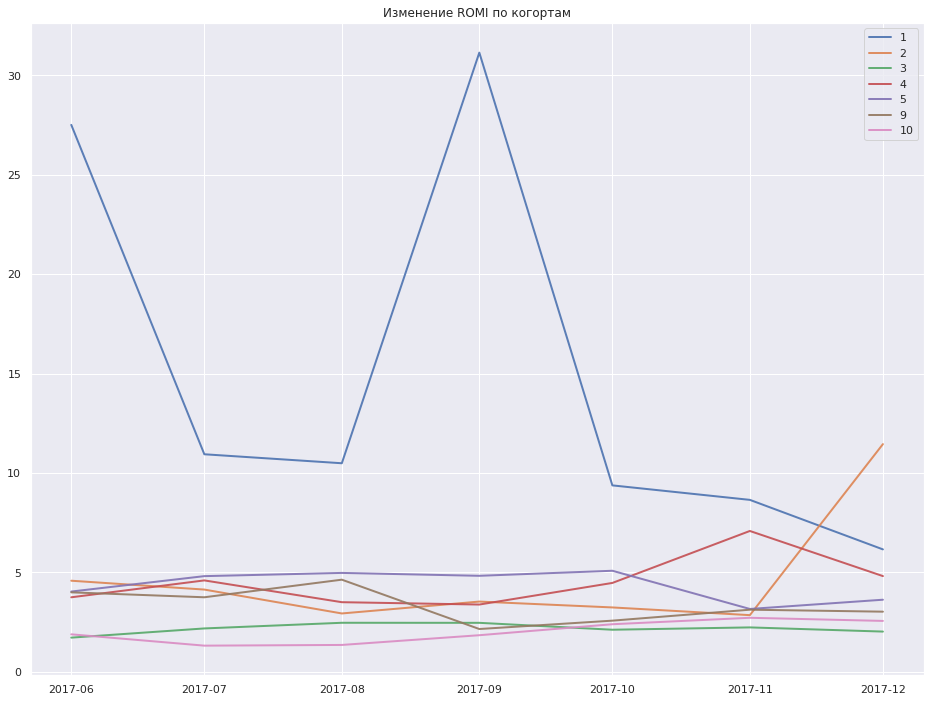

In [106]:
df = romi_tbl.pivot_table(index='first_activity_month', columns='source_id', values='romi', aggfunc='mean')
plt.figure(figsize=(16,12))
for row in df:
    plt.plot(df.index.values, df[row], marker='', linewidth=2, alpha=0.9, label=row)
plt.legend()
plt.title("Изменение ROMI по когортам")
plt.show()

На графике хорошо видно, что во ROMI во всех когортах пользователей из первого канала привлечения оказался не просто самым высоким, а прям в разы выше, чем во всех других каналах. Т.е. пользователи пришедшие из этого канала приносят значительно больше денег компании, чем все остальные. 3 канал не показывает высокий ROMI (конечно же в первую очередь за счёт высокой CAC), что делает этот источник трафика ещё менее привлекательным. А вот 4, 5 и 2-ой каналы стоит рассмотреть внимательно, к тому же 4 имеет самую низкую стоимость привлечения пользователей.

In [107]:
final_report = romi_tbl.groupby('source_id')[['romi','cac',5]].mean()
final_report.columns = ['romi', 'cac', '6m_ltv']
final_report.sort_values(by='romi', ascending=False)


,romi,cac,6m_ltv
source_id,,,
1,14.896659,0.962006,13.752681
2,4.676013,1.743152,8.537366
4,4.514961,1.052360,4.520586
5,4.361061,1.132403,4.830734
9,3.322886,1.083138,3.438994
3,2.172757,2.080236,4.522503
10,2.009816,1.314012,2.622978


## Выводы

    Для анализа эффективности источников трафика были использованы данные по всем посещения сервиса за год, данные о всех покупках этих пользователей за год и данные о расходах на рекламные каналы. На основе данных о посещения и покупка были расчитаны средний чек, среднее кол-во покупок, частота посещения сервиса и прочие, а также LTV. Т.е. был сформирован некоторый поведенческий портрет среднестатистического пользователя. С помощью данных о рекламных каналах была не только получена стоимость привлечения пользователя в конкретный месяц из конкретного канала, но и расчитан ROMI, а также сопоставлены расходы на маркетинг и количество пришедших пользователей в сервис. На основании ислледования получилось сделать следующие выводы:
    1. Стоит сделать упор на 1, 2, 4 и 5 каналы трафика, они имеют невысокую стоимость привлечения пользователя, а пользователи из этих каналов имеют высокий LTV, соответственно приносят больше прибыли компании. За счёт того, что в рамках исследования были посчитаны показатели LTV и текущие значение CAC - их может использовать отдел маркетинга для понимания своих возможностей по стоимости привлечения пользователей.
    2. Самый используемый сейчас 3 канал оказывается предпоследним по эффективности (возможно это объявления в лифте), пользователи пришедшие оттуда окупают расходы на привлечение, но 28% бюджета можно было бы распределеить на другие, более эффективные каналы.
    3. Для рекомендаций по остальным каналам было бы хорошо понимать, что это за каналы (возможно 10 это SEO, что в перспективе принесёт значительно более высокие результаты)
    4. Продуктовые метрики:
     - пользователи заходят в сервис в среднем один раз в месяц - это не звучит хорошо. Возможно они заходят с какой-то регулярностью для одного и того же действия. Дополнительно можно проанализировать в какие дни недели или месяца чаще всего выполняется вход
     - чаше всего сессия длится 1 минуту, но можно сказать что среднее время проводимое на сайте 5 минут (как минимум половина пользователей проводит столько и больше на сайте) - этого должно быть достаточно для изучения какого-то контента на сайте
     - retention rate падает сразу после первого месяца до примерно 4% и с течением времени не сильно снижается дальше, что может говорить о том, что сервисом продолжают пользоваться только те, кому сервис реально полезен и продолжают пользоваться им постоянно. Возможно стоит разобраться с тем, что не устраивает 96% 
    5. Метрики электронной коммерции:
     - половина пользователей (которые вообще что-то покупают в сервисе) делают первую покупку в течение 21 минуты с первого входа в сервис, а т.к. в среднем пользователи проводят в день около 1 сессии - это происходит в первую сессию. Возможно есть смысл посмотреть, как изменяется длительность сессий с первой по дальнейшие. При этом для остальных пользователей срок покупки растягивается на несколько месяцев вперёд (вплоть до года, а может и больше, но у нас дальше нет данных)
     - за первые 6 месяцев в среднем получается 1,3 покупки на пользователя, после 6-го месяца этот показатель растёт не так стремительно, но в первой когорте получилось более двух покупок на одного пользователя
     - средний LTV в первый месяц по всем исследованным когортам превышал средний CAC, а значит уже с первого месяца все пользователи начали приносить компании прибыль. Это конечно же хорошо
    6. На данный момент самыми прибыльными для компании (по результатам первых 6-ти месяцев) оказались когорты декабря, ноября и октября 2017 года. С них можно брать пример. В целом можно сказать, что с каждой следующей когортой прибыль компании с неё увеличивалась, но последующие данные по когортам дадут более актуальную информацию. Для их оценки сейчас было бы хорошо на основании имеющихся данных посмотрить прогноз.

In [108]:
romi_tbl['revenue'] = (romi_tbl[5]*romi_tbl['uid'])-romi_tbl['costs']
romi_tbl.groupby('first_activity_month')['revenue'].sum().sort_values(ascending=False)

first_activity_month
2017-12-01    126953.847278
2017-11-01     98709.920932
2017-10-01     95501.243056
2017-09-01     95420.934206
2017-06-01     62844.742255
2017-07-01     52129.441843
2017-08-01     39277.762330
Name: revenue, dtype: float64